## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [10]:
## Load in the data set (Internet Access needed)

#url not working
#url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
#diabetes_df = pd.read_csv(url, names=names)

diabetes_df = pd.read_csv("pima-indians-diabetes.csv",names=names)

In [12]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
188,8,109,76,39,114,27.9,0.640,31,1
586,8,143,66,0,0,34.9,0.129,41,1
683,4,125,80,0,0,32.3,0.536,27,1
249,1,111,86,19,0,30.1,0.143,23,0
693,7,129,68,49,125,38.5,0.439,43,1


In [13]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [14]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [15]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [16]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.771
roc-auc is 0.833


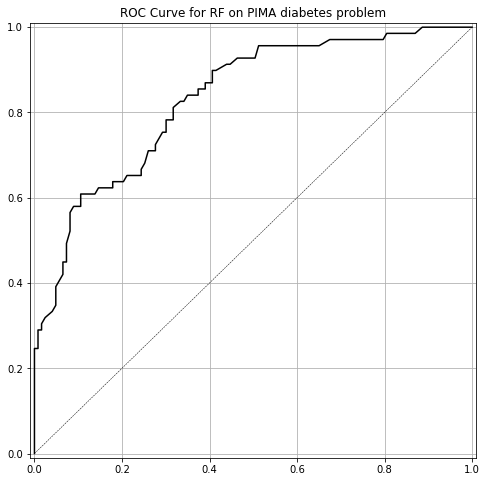

In [18]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [19]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [20]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [21]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [22]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 702us/step - loss: 1.0712 - acc: 0.3576 - val_loss: 1.1019 - val_acc: 0.3750
Epoch 2/200
576/576 [==============================] - 0s 91us/step - loss: 1.0335 - acc: 0.3594 - val_loss: 1.0630 - val_acc: 0.3750
Epoch 3/200
576/576 [==============================] - 0s 84us/step - loss: 0.9988 - acc: 0.3663 - val_loss: 1.0272 - val_acc: 0.3750
Epoch 4/200
576/576 [==============================] - 0s 71us/step - loss: 0.9668 - acc: 0.3646 - val_loss: 0.9941 - val_acc: 0.3750
Epoch 5/200
576/576 [==============================] - 0s 79us/step - loss: 0.9373 - acc: 0.3698 - val_loss: 0.9637 - val_acc: 0.3802
Epoch 6/200
576/576 [==============================] - 0s 76us/step - loss: 0.9102 - acc: 0.3802 - val_loss: 0.9357 - val_acc: 0.3854
Epoch 7/200
576/576 [==============================] - 0s 71us/step - loss: 0.8853 - acc: 0.3889 - val_loss: 0.9099 - val_acc: 0.3906
Epoch 8/200
576

576/576 [==============================] - 0s 63us/step - loss: 0.5682 - acc: 0.7396 - val_loss: 0.5746 - val_acc: 0.7083
Epoch 62/200
576/576 [==============================] - 0s 61us/step - loss: 0.5670 - acc: 0.7413 - val_loss: 0.5733 - val_acc: 0.7083
Epoch 63/200
576/576 [==============================] - 0s 70us/step - loss: 0.5659 - acc: 0.7431 - val_loss: 0.5721 - val_acc: 0.7135
Epoch 64/200
576/576 [==============================] - 0s 71us/step - loss: 0.5648 - acc: 0.7431 - val_loss: 0.5709 - val_acc: 0.7135
Epoch 65/200
576/576 [==============================] - 0s 67us/step - loss: 0.5636 - acc: 0.7431 - val_loss: 0.5698 - val_acc: 0.7135
Epoch 66/200
576/576 [==============================] - 0s 92us/step - loss: 0.5626 - acc: 0.7431 - val_loss: 0.5686 - val_acc: 0.7188
Epoch 67/200
576/576 [==============================] - 0s 107us/step - loss: 0.5615 - acc: 0.7431 - val_loss: 0.5675 - val_acc: 0.7188
Epoch 68/200
576/576 [==============================] - 0s 89us/ste

576/576 [==============================] - 0s 67us/step - loss: 0.5208 - acc: 0.7535 - val_loss: 0.5274 - val_acc: 0.7344
Epoch 122/200
576/576 [==============================] - 0s 67us/step - loss: 0.5203 - acc: 0.7535 - val_loss: 0.5269 - val_acc: 0.7344
Epoch 123/200
576/576 [==============================] - 0s 71us/step - loss: 0.5197 - acc: 0.7517 - val_loss: 0.5265 - val_acc: 0.7344
Epoch 124/200
576/576 [==============================] - 0s 72us/step - loss: 0.5192 - acc: 0.7552 - val_loss: 0.5260 - val_acc: 0.7396
Epoch 125/200
576/576 [==============================] - 0s 63us/step - loss: 0.5187 - acc: 0.7517 - val_loss: 0.5255 - val_acc: 0.7396
Epoch 126/200
576/576 [==============================] - 0s 70us/step - loss: 0.5182 - acc: 0.7500 - val_loss: 0.5250 - val_acc: 0.7396
Epoch 127/200
576/576 [==============================] - 0s 65us/step - loss: 0.5177 - acc: 0.7517 - val_loss: 0.5246 - val_acc: 0.7396
Epoch 128/200
576/576 [==============================] - 0s 71

576/576 [==============================] - 0s 70us/step - loss: 0.4970 - acc: 0.7622 - val_loss: 0.5064 - val_acc: 0.7604
Epoch 182/200
576/576 [==============================] - 0s 70us/step - loss: 0.4967 - acc: 0.7622 - val_loss: 0.5061 - val_acc: 0.7604
Epoch 183/200
576/576 [==============================] - 0s 68us/step - loss: 0.4964 - acc: 0.7622 - val_loss: 0.5058 - val_acc: 0.7604
Epoch 184/200
576/576 [==============================] - 0s 79us/step - loss: 0.4961 - acc: 0.7622 - val_loss: 0.5056 - val_acc: 0.7604
Epoch 185/200
576/576 [==============================] - 0s 74us/step - loss: 0.4958 - acc: 0.7622 - val_loss: 0.5053 - val_acc: 0.7604
Epoch 186/200
576/576 [==============================] - 0s 88us/step - loss: 0.4955 - acc: 0.7622 - val_loss: 0.5051 - val_acc: 0.7656
Epoch 187/200
576/576 [==============================] - ETA: 0s - loss: 0.4479 - acc: 0.812 - 0s 84us/step - loss: 0.4952 - acc: 0.7622 - val_loss: 0.5048 - val_acc: 0.7656
Epoch 188/200
576/576 [=

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [ ]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

In [ ]:
y_pred_prob_nn_1[:10]

In [ ]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [ ]:
run_hist_1.history.keys()

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [ ]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [ ]:
# Type your code here to with layer 1,2 having activation relu and layer 3 with activation sigmoid

In [ ]:
# Type your code here to plot the loss accuracy and ROC curve